In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import numpy as np
import plotly.graph_objects as go
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import jax
from copy import deepcopy


jax.config.update('jax_platform_name', 'cpu')


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    

In [3]:
from synbio_morpher.scripts.parameter_based_simulation.run_parameter_based_simulation import make_interaction_matrices
from synbio_morpher.utils.common.testing.minimal_sim import mini_sim
from synbio_morpher.utils.data.data_format_tools.common import load_json_as_dict
from synbio_morpher.utils.misc.string_handling import prettify_keys_for_label
from synbio_morpher.utils.misc.numerical import make_symmetrical_matrix_from_sequence
from synbio_morpher.utils.parameter_inference.interpolation_grid import create_parameter_range

# Load analytic

In [4]:
sdir = '../data/parameter_based_simulation/2023_08_24_114212'
analytic_name = 'precision'
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if analytic_name in f][0])
config = load_json_as_dict('../data/parameter_based_simulation/2023_08_24_114212/experiment.json')['config_params']

In [5]:
param_range = create_parameter_range(config['parameter_based_simulation'])

x = np.load(fn)

# Species settings

In [7]:
n_species = x.shape[0]
choice11 = 'RNA_0'
choice12 = 'RNA_0'
choice21 = 'RNA_0'
choice22 = 'RNA_1'
slider1 = 'RNA_0'
slider2 = 'RNA_2'

output = 'RNA_1'

species_names = [f'RNA_{i}' for i in range(n_species)]

output_idx = species_names.index(output)
sig_idx = 0
paired_idxs = np.concatenate([np.triu_indices(3)[0][:, None], np.triu_indices(3)[1][:, None]], axis=1)
paired_idxs = [tuple(p) for p in paired_idxs]
choice1_idx = paired_idxs.index((species_names.index(choice11), species_names.index(choice12)))
choice2_idx = paired_idxs.index((species_names.index(choice21), species_names.index(choice22)))
static = 2
slider_idx = paired_idxs.index((species_names.index(slider1), species_names.index(slider2)))


# Simple 3D vis

In [47]:


slices = [static] * (len(x.shape) - 1)
slices[choice1_idx] = slice(x.shape[choice1_idx+1])
slices[choice2_idx] = slice(x.shape[choice2_idx+1])
z_data = x[tuple([output_idx] + slices)]


fig = go.Figure(data=[go.Surface(z=z_data)])

fig.update_layout(title=prettify_keys_for_label(analytic_name),
                  autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
    xaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice11}-{choice12}"
    ),
    yaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice21}-{choice22}"
    ), 
    zaxis=dict(title=prettify_keys_for_label(analytic_name))
))
# fig.update_xaxes(labelalias=<VALUE>)
# fig.show()

# Stacked

In [48]:
slices = [slice(x.shape[1]), slice(x.shape[2]), 0, 0, 0, 0]
xmax = np.max(x[tuple([slice(x.shape[0])] + slices)])

surfs = []
pi = 0
for si in range(n_species):
    if si == sig_idx:
        continue
    surfs.append(go.Surface(z=x[tuple([si] + slices)] +
                 xmax * pi, showscale=False, opacity=0.9))
    pi += 1
    # surfs.append(go.Surface(z=x[si, :, :, 0, 0, 0, 0] + si * xmax, showscale=False, opacity=0.9))

fig = go.Figure(data=surfs)

fig.update_layout(title=prettify_keys_for_label(analytic_name), autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene=dict(
    xaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice11}-{choice12}"
    ),
    yaxis=dict(
        tickmode="array",
        ticktext=[f'{p:.0e}' for p in param_range],
        tickvals=np.arange(x.shape[1]),
        title=f"{choice21}-{choice22}"
    ), 
    zaxis=dict(title=prettify_keys_for_label(analytic_name))
))

fig.write_html(f'stacked_{analytic_name}_{choice11}-{choice12}.html')

# Slider

In [49]:

fig = go.Figure()

for i, step in enumerate(param_range):
    
    slices = [static] * (len(x.shape) - 1)
    slices[choice1_idx] = slice(x.shape[choice1_idx+1])
    slices[choice2_idx] = slice(x.shape[choice2_idx+1])
    slices[slider_idx] = i

    xmax = np.max(x[tuple([slice(x.shape[0])] + slices)])
    pi = 0
    for si in range(n_species):
        if si == sig_idx:
            continue
        fig.add_trace(
            go.Surface(z=x[tuple([si] + slices)] + xmax * pi,
                       visible=False,
                       name="[3] = " + f'{step:.2e}',
                       showscale=False, opacity=1.0),
        )
        pi += 1
        break

fig.data[0].visible = True

steps = []
for i, pr in zip(range(len(fig.data)), param_range):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to step: " + f'{pr:.2e}'}],  # layout attribute
        label=f'{pr:.02}'
    )
    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": f"Interaction strength {slider1}-{slider2}: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders,
    title=prettify_keys_for_label(analytic_name) + f' for {output}',
    scene=dict(
        xaxis=dict(
            tickmode="array",
            ticktext=[f'{p:.0e}' for p in param_range],
            tickvals=np.arange(x.shape[1]),
            title=f"{choice11}-{choice12}"
        ),
        yaxis=dict(
            tickmode="array",
            ticktext=[f'{p:.0e}' for p in param_range],
            tickvals=np.arange(x.shape[1]),
            title=f"{choice21}-{choice22}"
        ),
        zaxis=dict(title=prettify_keys_for_label(analytic_name) + ' ' + output)
    )
)

fig.write_html(f'slider_{analytic_name}_{choice11}-{choice12}.html')

## Slider show

In [1]:
# fig.show()

# Adaptability

In [12]:
sdir = '../data/parameter_based_simulation/2023_08_24_114212'
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'sensitivity' in f][0])
s = np.load(fn)
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'precision' in f][0])
p = np.load(fn)
fn = os.path.join(sdir, [f for f in os.listdir(sdir) if 'overshoot' in f][0])
o = np.load(fn)

config = load_json_as_dict(os.path.join(sdir, 'experiment.json'))['config_params']
param_range = create_parameter_range(config['parameter_based_simulation'])


In [18]:
hue = np.log10(o[1:].flatten())
hue[hue == -np.inf] = 2 * hue[hue > -np.inf].min()

/tmp/ipykernel_200515/1577417065.py:1: RuntimeWarning: divide by zero encountered in log10
  hue = np.log10(o[1:].flatten())


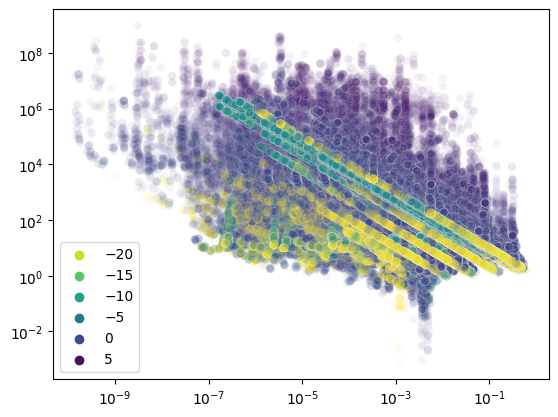

In [20]:
sns.scatterplot(x=s[1:].flatten(), y=p[1:].flatten(), hue=hue, alpha=0.05, palette='viridis_r')
plt.xscale('log')
plt.yscale('log')

# Find Max

In [6]:
sdir = '../data/parameter_based_simulation/2023_08_24_114212'
a = {}
for f in os.listdir(sdir):
    if f.endswith('npy'):
        a[f.split('.')[0]] = np.load(os.path.join(sdir, f))

In [7]:
list(a.keys())

['fold_change',
 'response_time_wrt_species-6',
 'overshoot_asratio',
 'max_amount',
 'overshoot',
 'initial_steady_states',
 'sensitivity_wrt_species-6',
 'min_amount',
 'precision_wrt_species-6',
 'steady_states']

In [41]:
def find_top_n_peaks(arrs: list, n: int):
    """ Find the top n peaks across the multi-dimensional arrays in arrs """
    top_peaks = []
    for ni in range(n):

        objective = arrs[0] / arrs[0].max()
        for arr in arrs[1:]:
            objective += arr / arr.max()
        top_peak = np.argmax(objective)
        top_peak_idx = np.unravel_index(top_peak, arr.shape)

        for i in range(len(arrs)):
            arrs[i][top_peak_idx] = 0

        # next_top_peaks = find_top_n_peaks(arrs, n=n-1)
        # if (np.sum(top_peak_idx) >= np.sum(next_top_peaks[-1]) + 1) & (
        #     np.sum(top_peak_idx) <= np.sum(next_top_peaks[-1]) - 1
        # ):
        top_peaks.append(top_peak_idx)
        # top_peaks = top_peaks + next_top_peaks

    return top_peaks


def filter_top_peaks(top_indices, radius: int):
    chosen = [0]
    for i, t in enumerate(top_indices[1:]):
        # if (np.sum(np.abs(np.array(t) - np.array(top_indices[i]))) > radius):
        # if np.sum(np.power(np.array(t) - np.array(top_indices[i]), 0.5)) > radius:
        if np.sum((np.array(t) - np.array(top_indices[i])) == 0) == 0:
            chosen.append(i+1)
    top_indices = [top_indices[i] for i in chosen]
    return top_indices

### Get top peaks

In [44]:
n_top = 10000
i_spec = 1
radius = 1

pp = np.where(a['precision_wrt_species-6'] > 1e1,
              1e1, a['precision_wrt_species-6'])
# Overshoot / signal diff
oo = np.where((a['max_amount'][0] - a['initial_steady_states'][0]) == 0,
              0, a['overshoot'] / (a['max_amount'][0] - a['initial_steady_states'][0]))
oo = np.where(oo < 1e-4, 0, oo)
# oo = np.where(a['overshoot'] < 1e-4, 0, np.where(a['initial_steady_states']
#               == 0, a['overshoot'], a['overshoot'] / a['initial_steady_states']))
# oo = np.where(oo < 1e-4, 0, np.where(a['initial_steady_states']
#               == 0, a['overshoot'], a['overshoot'] / a['initial_steady_states']))
arrs = [a['sensitivity_wrt_species-6'][i_spec], pp[i_spec], oo[i_spec]]
top_indices = find_top_n_peaks(deepcopy(arrs), n=n_top)
n_ind = len(top_indices)
n_prev = 0
while n_ind != n_prev:
    n_prev = len(top_indices)
    top_indices = filter_top_peaks(top_indices, radius=radius)
    n_ind = len(top_indices)

print(len(top_indices))
top_indices

/tmp/ipykernel_448938/1681457973.py:9: RuntimeWarning: invalid value encountered in divide
  0, a['overshoot'] / (a['max_amount'][0] - a['initial_steady_states'][0]))


114


[(0, 5, 0, 8, 8, 4),
 (1, 4, 2, 7, 4, 8),
 (3, 5, 3, 6, 8, 5),
 (2, 4, 2, 7, 5, 4),
 (1, 5, 4, 6, 7, 8),
 (0, 4, 3, 8, 5, 6),
 (2, 5, 6, 6, 4, 1),
 (0, 4, 2, 7, 7, 6),
 (2, 5, 3, 8, 1, 1),
 (0, 4, 0, 7, 7, 5),
 (2, 5, 4, 6, 6, 7),
 (0, 4, 0, 7, 4, 6),
 (2, 5, 3, 6, 5, 8),
 (0, 4, 1, 7, 4, 6),
 (3, 5, 2, 6, 3, 1),
 (2, 4, 1, 8, 4, 6),
 (3, 5, 5, 7, 5, 5),
 (2, 4, 3, 8, 7, 8),
 (8, 5, 8, 4, 5, 3),
 (3, 4, 2, 8, 4, 7),
 (4, 5, 3, 7, 7, 5),
 (0, 4, 1, 6, 5, 7),
 (4, 5, 0, 7, 7, 4),
 (0, 4, 2, 6, 5, 7),
 (8, 5, 5, 4, 3, 0),
 (1, 4, 2, 6, 5, 7),
 (2, 5, 0, 8, 4, 5),
 (0, 4, 3, 7, 6, 8),
 (7, 5, 7, 2, 3, 5),
 (1, 4, 3, 6, 4, 6),
 (7, 5, 7, 0, 2, 5),
 (3, 4, 0, 7, 5, 8),
 (0, 5, 1, 8, 3, 7),
 (3, 4, 0, 7, 4, 6),
 (2, 5, 1, 8, 3, 7),
 (8, 6, 4, 7, 4, 4),
 (4, 5, 2, 6, 5, 7),
 (8, 6, 3, 8, 4, 6),
 (3, 5, 0, 6, 1, 3),
 (0, 6, 4, 8, 5, 6),
 (7, 5, 5, 1, 2, 5),
 (1, 6, 4, 8, 5, 6),
 (7, 5, 6, 0, 3, 8),
 (8, 6, 4, 8, 4, 5),
 (1, 5, 8, 6, 5, 8),
 (7, 6, 3, 7, 4, 4),
 (2, 5, 8, 6, 5, 7),
 (8, 6, 4, 8,

In [125]:
# param_range[top_indices]

In [45]:
print('senstivity \t overshoot \t precision')
for t in top_indices:
    print(a['sensitivity_wrt_species-6'][1][tuple(t)], '\t', a['overshoot'][1][tuple(t)], '\t', a['precision_wrt_species-6'][1][t])

senstivity 	 overshoot 	 precision
2.3217888e-06 	 70.13575 	 25744.67
0.001434192 	 41.57659 	 25.488306
0.0011831371 	 41.533394 	 86.402115
0.0013584319 	 40.762085 	 10.354895
0.0020104647 	 40.30114 	 45.678757
0.0009047448 	 40.204407 	 24.874247
0.0013827597 	 40.02172 	 101.55459
0.0003428464 	 38.02175 	 36.95731
0.0026419966 	 37.210342 	 29.718481
0.00052111445 	 37.555794 	 23.436104
0.0018939709 	 37.010445 	 68.84685
0.0014477911 	 33.97073 	 16.504772
0.00087779795 	 34.03415 	 16.265316
0.001453563 	 33.963352 	 16.463081
0.004188285 	 33.104935 	 33.189297
0.001580944 	 33.66238 	 15.428708
0.0042509623 	 33.0384 	 31.899027
0.00071982044 	 32.413994 	 18.930899
0.25970277 	 5.421403 	 11.242551
0.0032210776 	 31.313477 	 11.464636
0.0040621934 	 31.028557 	 31.874664
0.00023391834 	 31.692421 	 77.36925
0.0037416932 	 31.080162 	 34.97178
0.00027138978 	 31.472435 	 66.74549
0.27824786 	 4.2254286 	 10.186742
0.00027311197 	 31.427101 	 66.321075
0.00039091503 	 31.41

In [46]:
config['simulation']

{'dt0': 0.01,
 't0': 0,
 't1': 100,
 'tmax': 120000,
 'solver': 'diffrax',
 'use_batch_mutations': True,
 'batch_size': 10000,
 'max_circuits': 20000,
 'device': 'gpu',
 'threshold_steady_states': 0.05,
 'use_rate_scaling': True}

### Run mini sim

In [47]:
saves = {}
for i, ti in enumerate(top_indices):
    r, analytics, y, t = mini_sim(*param_range[np.array(ti)])
    saves[i] = {
        'analytics': analytics,
        'y': y,
        't': t
    }

xla_bridge.py:backends():450: Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: Interpreter Host CUDA INFO
xla_bridge.py:backends():450: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client' INFO
xla_bridge.py:backends():450: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this. INFO


0 	 0.0034371186 	 65.82424 	 8204.133
1 	 0.004862404 	 23.470009 	 966.5302
2 	 0.0013850782 	 42.304535 	 5703.9004
3 	 0.0035184491 	 23.563755 	 459.06976
4 	 0.0036565347 	 38.371765 	 1991.0935
5 	 0.0017763572 	 30.058289 	 2563.334
6 	 0.004999642 	 33.765717 	 1792.2738
7 	 0.001427101 	 27.812828 	 1080.6522
8 	 0.006087621 	 40.190598 	 2955.516
9 	 0.0022294016 	 32.438095 	 768.32495
10 	 0.0035278432 	 36.814606 	 3002.4187
11 	 0.0048817084 	 22.754478 	 769.7956
12 	 0.00086440437 	 33.761948 	 2007.1539
13 	 0.0048832507 	 22.750198 	 769.9346
14 	 0.0058849948 	 32.84059 	 2726.8289
15 	 0.0049421834 	 22.76699 	 778.04926
16 	 0.006677689 	 32.91044 	 2931.069
17 	 0.0015278313 	 24.380539 	 939.5723
18 	 0.2593696 	 5.1382 	 11.340988
19 	 0.005532019 	 23.116325 	 2145.7803
20 	 0.0064191134 	 32.311836 	 321.21338
21 	 0.0013381117 	 28.131767 	 4400.3657
22 	 0.011243767 	 35.463066 	 222.47504
23 	 0.0013483235 	 27.967827 	 4272.3467
24 	 0.27012217 	 4.066665

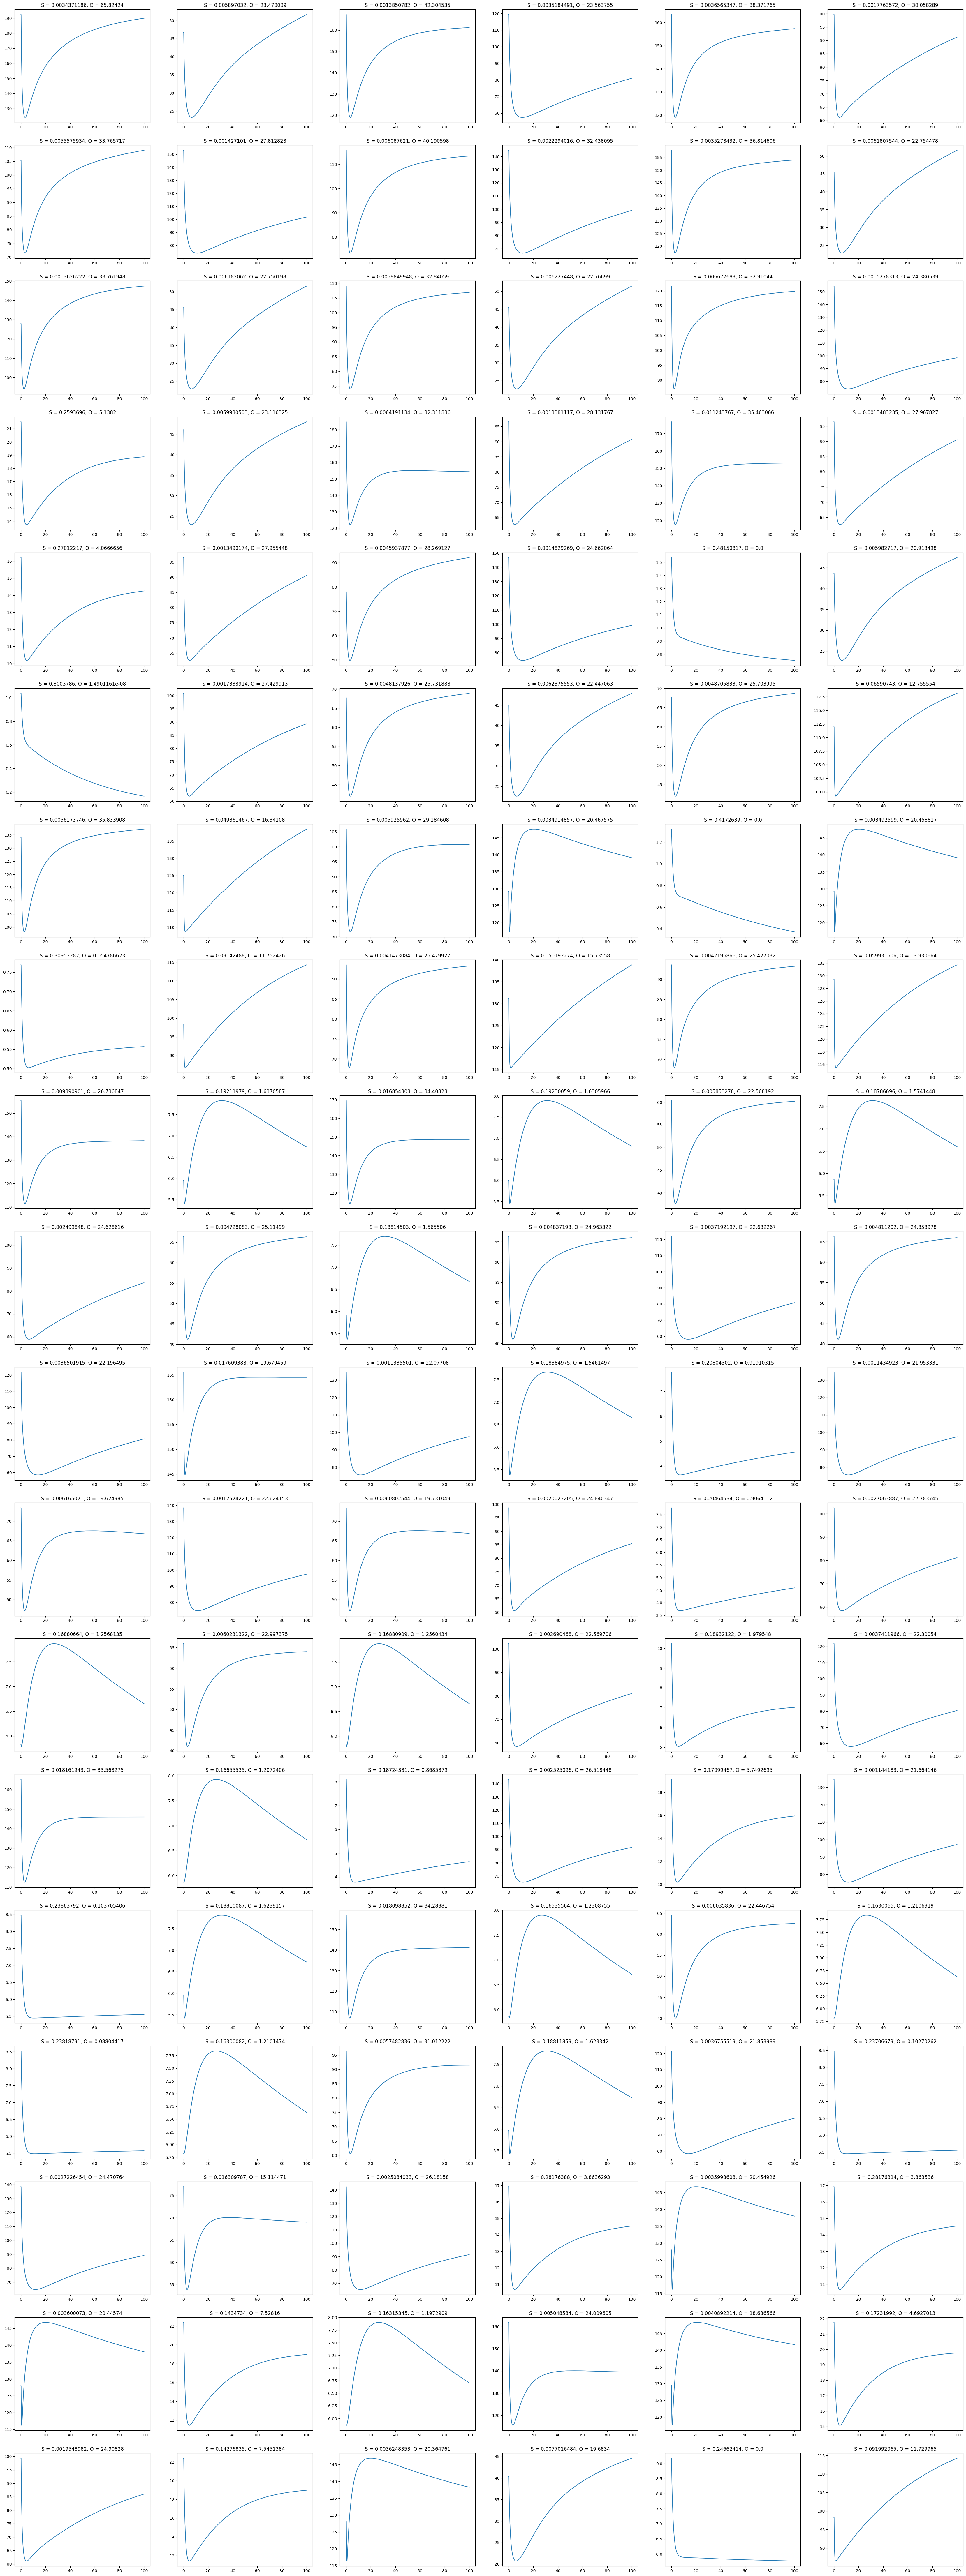

In [48]:
n_rows = np.ceil(len(saves) / 6).astype(int)
n_cols = np.ceil(len(saves) / n_rows).astype(int)
plt.figure(figsize=(7*n_cols, 6*n_rows))
for i, run in saves.items():
    ax = plt.subplot(n_rows, n_cols, i+1)
    plt.plot(run['t'], run['y'][:, 7])
    plt.title('S = ' + str(run['analytics']['sensitivity_wrt_species-6'][7]) +
              ', O = ' + str(run['analytics']['overshoot'][7]))

    sensitivity = np.absolute(np.divide(
        np.divide(
            run['analytics']['min_amount'][7] -
            run['analytics']['initial_steady_states'][7],
            run['analytics']['initial_steady_states'][7]),
        np.divide(
            run['analytics']['max_amount'][6] -
            run['analytics']['initial_steady_states'][6],
            run['analytics']['initial_steady_states'][6])
    ))
    print(i, '\t', sensitivity, '\t', run['analytics']['overshoot'][7], '\t', run['analytics']['precision_wrt_species-6'][7])

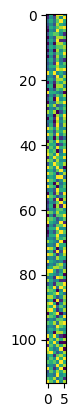

In [49]:
plt.imshow(np.log10(param_range[top_indices]))

In [166]:

unbound_species = ['RNA_0', 'RNA_1', 'RNA_2']
species = ['RNA_0-0', 'RNA_0-1', 'RNA_0-2', 'RNA_1-1', 'RNA_1-2', 'RNA_2-2', 'RNA_0', 'RNA_1', 'RNA_2']
inds = [i for i, s in enumerate(species) if s in unbound_species]

In [168]:
analytics['sensitivity_wrt_species-6'][:]

Array([3.0880556 , 0.17996687, 1.0277492 , 0.02246778, 0.04672105,
       0.03539252, 1.        , 0.38737464, 0.02014509], dtype=float32)

: 

In [91]:
analytics['precision_wrt_species-6']
# Array([2.0208731e+00, 7.0501550e+02, 7.0507782e+02, 5.7925303e-03,
#        6.6594379e+02, 7.3779352e+02, 7.0101660e+02, 7.0101703e+02,
#        7.0101733e+02], dtype=float32)

Array([ 0.33718005,  1.6675429 ,  1.3405542 , 25.240751  , 45.556717  ,
        4.9638042 ,  1.0338407 ,  7.673475  ,  9.342553  ], dtype=float32)

In [ ]:
num_species = 3
interaction_matrices, all_interaction_strength_choices = make_interaction_matrices(
    num_species=num_species, interaction_strengths=param_range,
    num_unique_interactions=6, starting_iteration=0, end_iteration=10)

for i, interaction_strength_choices in enumerate(all_interaction_strength_choices):
    idxs = [slice(0, num_species)] + [[strength_idx] for strength_idx in interaction_strength_choices]
    r, analytics = mini_sim(*interaction_matrices[i][np.triu_indices(num_species)])

    print(f'\nInteraction {i}:')
    print('prev', a['sensitivity_wrt_species-6'][tuple(idxs)])
    print('now', analytics['sensitivity_wrt_species-6'])
    

In [158]:

r, analytics = mini_sim(*interaction_matrices[0][np.triu_indices(n_species)])


In [159]:
n_species = 3
for interaction_strength_choices in all_interaction_strength_choices[:1]:
    idxs = [slice(0, n_species)] + [[strength_idx] for strength_idx in interaction_strength_choices]